 # EKG Project

Given a sequence $F$ that is periodic or nearly periodic, we would like to find its period. We start with the observation that if a sequence $F$ has period $p$, for all integers $k$ we have
$$
     (F_k - F_{k+p})^2 = 0.
$$
Summing this over $k$ from zero to any integer $N-1$ gives
$$
     \sum_{k=0}^{N-1} (F_k - F_{k+p})^2 = 0.
$$
For a given sequence $F$, this is an equation to solve for the period $p$. Of course one solution to the equation is $p = 0$, but we need a nonzero solution to find the period. Since $\sum_{k=0}^{N-1} (F_k - F_{k+p})^2 \geq 0$ for all integers $p$, we are looking for the integer that _minimizes_ this sum. So this this a minimization problem.

Presumably if $F$ is nearly periodic, the number $p$ that minimizes the sum $\sum_{k=0}^{N-1} (F_k - F_{k+p})^2 = 0$ is in some sense an approximate period. But we haven't attempted to define _nearly periodic_.

To find the minimum, we'll use the Julia package https://github.com/JuliaNLSolvers/Optim.jl/

In [1]:
using LinearAlgebra

In [2]:
using Gadfly

In [3]:
using Optim

In [4]:
using Memoize

In [5]:
using Random

In [6]:
using Interpolations

In [7]:
using Dierckx

LoadError: ArgumentError: Package Dierckx not found in current path:
- Run `import Pkg; Pkg.add("Dierckx")` to install the Dierckx package.


In [8]:
rng = MersenneTwister(0);

In [9]:
"""
For an array `a` and integers `n` and `N,` the call `Q(a,n,N)` returns `sum((a[k] - a[k+n])^2,k,1,N)`. This is a
memoizing function.
"""
function Q(a,n,N) 
    a = a[1:N] - a[n+1:n+N]
    dot(a,a)
end

Q

Notice the documentation string--we like them:

In [10]:
? Q

search: Q QR qr qr! quote QuoteNode QuickSort QRPivoted Quadratic LQ lq lq! sqrt



For an array `a` and integers `n` and `N,` the call `Q(a,n,N)` returns `sum((a[k] - a[k+n])^2,k,1,N)`. This is a memoizing function.


Let's test our theory.  We'll generate a sequence that is nearly period (or period) and look at the graph of $Q$. Here is our first example. The sequence is generated with a triangular wave. Its period is 200:

In [11]:
range1 = 0:999;

In [12]:
L = [asin(sin(pi*k/100)) + 0.6*asin(sin(pi*k/50))+ 0.2*randn(rng, Float64) for k in range1];

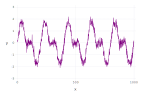

In [13]:
plot(x=range1,y=L, Geom.line, color=[colorant"purple"])

Generate the sequence we called $Q$. Well use $N$ = 50. That's 1/4 of a period. The graph of $Q$ should have minima at 0,200, 400, 600, ...

In [14]:
range2 = 0:600;

In [15]:
LL = [Q(L,k,50) for k in range2];

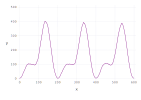

In [16]:
plot(x=range2,y=LL, Geom.line, color=[colorant"purple"])

Here is the function we need to minimize:

In [17]:
function mimimize_me(x)
   Q(L, convert(Int64, round(x)), 150)
end

mimimize_me (generic function with 1 method)

Instead of rounding $x$ to the nearest integer, I think we should linearly interpolate between $\lfloor x \rfloor$ and $\lceil x \rceil$. 

Let's look for a minimum in the interval $[100,300]$.

In [18]:
result = optimize(mimimize_me, 100, 300)

Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [100.000000, 300.000000]
 * Minimizer: 2.024052e+02
 * Minimum: 1.227464e+01
 * Iterations: 34
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 35

Looks like we found the period:

In [19]:
Optim.minimizer(result)

202.40524661433878

To linearly interpolate, we can do this

In [20]:
function mimimize_meto(x)
    x1 = convert(Int64, floor(x))
    x2 = convert(Int64, ceil(x))
    y1 = Q(L, x1, 150)
    y2 = Q(L, x2, 150)
    y1 + (y2-y1)*(x-x1)/(x2-x1)
end

mimimize_meto (generic function with 1 method)

In [21]:
result = optimize(mimimize_meto, 100, 300)

Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [100.000000, 300.000000]
 * Minimizer: 1.990000e+02
 * Minimum: 1.128470e+01
 * Iterations: 37
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 38

In [22]:
Optim.minimizer(result)

199.000002280718

Alternatively, we can expand `Q`
$$
     Q(n) = \sum_{k=0}^{N-1} (F_k - F_{k+n})^2 = 0.
$$
Thus
$$
  Q(n) = \sum_{k=0}^{N-1} F_k^2  - 2 \sum_{k=0}^{N-1} F_k F_{k+n} +  - \sum_{k=0}^{N-1} F_{k+n}^2
$$
The middle term, that is the sequence
$$
   n \mapsto \sum_{k=0}^{N-1} F_k F_{k+n}
$$
is an the _autocorrelation_ sequence for $F$. It has lots of nice properties; see https://en.wikipedia.org/wiki/Autocorrelation

We will model one period of a ecg as a piecewise linear function. We start with a function that does linear interpolation of two points in the plane, and then we build a function for defining a piecewise linear function.

In [23]:
"""
 Return the number `y` such that `(x,y)` is on the line that contains the points `(x0,y0)` and `(x1,y1)`.
"""
function linear_interpolation(x0::Real,x1::Real,y0::Real,y1::Real,x::Real)
    y0 + (y1-y0)*(x-x0)/(x1-x0)
    #fma((y1 - y0), ((x / (x1 - x0)) - (x0 / (x1 - x0))), y0)
end;

In [24]:
function qrs_complex(t0::Real, t1::Real,t2::Real,t3::Real, t4::Real, t5::Real, t6::Real, 
                     e0::Real, e1::Real,e2::Real,e3::Real, e4::Real, e5::Real, e6::Real, t::Real)
    t = mod(t, t6)     
    if t <= t1
        linear_interpolation(t0,t1,e0,e1,t)
    elseif t <= t2
         linear_interpolation(t1,t2,e1,e2,t)
    elseif t <= t3
         linear_interpolation(t2,t3,e2,e3,t) 
    elseif t <= t4
         linear_interpolation(t3,t4,e3,e4,t) 
    elseif t <= t5
         linear_interpolation(t4,t5,e4,e5,t)   
    else
         linear_interpolation(t5,t6,e5,e6,t)       
    end
end

qrs_complex (generic function with 1 method)

In [25]:
f = t ->  qrs_complex(0,1/6,2/6,3/6,4/6,5/6,6/6, 0,0,-2,10,-4,0,0,t);

In [26]:
g = t ->  f(t) + 0.2*randn(rng, Float64)

#7 (generic function with 1 method)

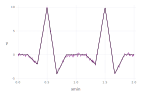

In [27]:
plot(layer(f, 0,2, color=[colorant"black"]), layer(g, 0,2, color=[colorant"purple"]))

Can we still find the period using our scheme? I'm not sure this will be important, but ...

In [28]:
range2 = 0:10^4;

In [29]:
N = 300;

In [30]:
range1 = 0:2*N;

In [31]:
L = [f(k/N) for k in range1];

In [32]:
LL = [g(k/N) for k in range1];

In [33]:
LLL = [Q(LL,n,100) for n in 0:500];

This graph should have minima at 100, 200, 300, .... And it does

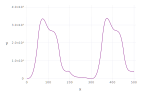

In [34]:
plot(x=1:500, y=LLL[1:500],Geom.line,color=[colorant"purple"])

In [35]:
function mimimize_meto(x)
    x1 = convert(Int64, floor(x))
    x2 = convert(Int64, ceil(x))
    y1 = Q(LL, x1, 50)
    y2 = Q(LL, x2, 50)
    linear_interpolation(x1,x2,y1,y2,x)
end

mimimize_meto (generic function with 1 method)

In [36]:
result = optimize(mimimize_meto, 10, 550);

In [37]:
Optim.minimizer(result)

288.9999999949991

I'm not sure that we will use the cubic spline interpolation stuff--for now, let's keep it

In [38]:
xs = 0 : 0.05 : 1

0.0:0.05:1.0

In [39]:
map(g,xs);

In [40]:
fn = CubicSplineInterpolation(xs, map(g,xs));

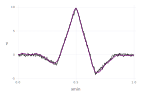

In [41]:
plot(layer(x -> fn(x),0,1,Geom.line, color=[colorant"purple"]), 
     layer(x -> g(x),0,1,Geom.line, color=[colorant"black"]))

Some tools we might :

In [42]:
"""
Return a degree `deg` polynomial function that is the least squares fit to the data
`(x1,y1), (x2, y2), ... , (xn,yn)` The first argument to `least_squares_fit` is an
array of the values `x1` through `xn` and the second argument is an array of the values `y1` through `yn`.

__Notes__ The arrays `x` and `y` should be the same length, but we don't check that's true. The degree `deg` should 
be positive, but we don't check that either.  This function evaluates the infinity norm matrix condition number 
of the normal equations matrix, but it doens't do anything with the value. Maybe it should issue or warning error when
the condition number is large.
"""
function least_squares_fit(x::Array, y::Array, deg::Integer)
    n = length(x)
    m = [x[i]^j for i=1:length(x), j=0:deg]
    y = [y[i] for i=1:length(y),j=1:1]
    mm = (transpose(m) * m)
    p, c = mm \ transpose(m) * y, cond(mm,Inf)
    t -> @evalpoly(t, p...)
end

least_squares_fit

In [43]:
? least_squares_fit

search: least_squares_fit



Return a degree `deg` polynomial function that is the least squares fit to the data `(x1,y1), (x2, y2), ... , (xn,yn)` The first argument to `least_squares_fit` is an array of the values `x1` through `xn` and the second argument is an array of the values `y1` through `yn`.

**Notes** The arrays `x` and `y` should be the same length, but we don't check that's true. The degree `deg` should  be positive, but we don't check that either.  This function evaluates the infinity norm matrix condition number  of the normal equations matrix, but it doens't do anything with the value. Maybe it should issue or warning error when the condition number is large.


There is 

https://www.simulkade.com/posts/2015-05-07-how-to-smoothen-noisy-data.html


but I'm not sure we'll use this. Here is a simple function for locally smoothing an array:

In [44]:
"""
For an array `y`, replace each of its members with a weighted arithemtic average of its symmtrically located
nearest neighbors. The weights are in the array `w.` The symmetrically located nearest neighbors to `y[k]` 
are `y[k-m], ... y[k-2], y[k-1], y[k], y[k+1], y[k+2], ..., y[k+m]` where `m = (length(w)-1)/2.`

__Note__ The length of the array of weights should be odd.
"""
function smooth(y::Array,w::Array)
   m =  convert(Int64, (length(w)-1)/2)
   [dot(y[k-m:k+m], w) for k in (m+1) : length(y) - m]
end

smooth

In [45]:
"""
For an arrays `a` and `b,` return the euclidean distance between the points `(a1,a1,...,an)` and
`(b1,b2,...,bn).`
"""
function distance(p0::Array,p1::Array)
   sqrt(dot(p0-p1,p0-p1))
end

distance

In [46]:
"""
Given three points in the `R^2`, this function finds the area of the triangle with these vertices. Each of the points 
`p0, p1` and `p2` are length two arrays.
"""
function area_triangle(p0::Array, p1::Array, p2::Array)
    x0,y0 = p0
    x1,y1 = p1
    x2,y2 = p2
    abs((x1-x0)*(y2-y0)-(x2-x0)*(y1-y0))
end        

area_triangle

In [47]:
"""
Given three points in the `R^2`, this function finds the reciprocal of the radius of the circle that interpolates 
these points . We represent points in `R^2` bt length two arrays.
"""
function curvature(p0::Array, p1::Array, p2::Array)
    2*area_triangle(p0,p1,p2)/(distance(p0,p1)*distance(p1,p2)*distance(p2,p0))
end  

curvature

In [48]:
function smoothed_curvature(x::Array, y::Array)
    n = length(x)
    y = smooth(y,[1/46,1/23,2/23,4/23,8/23,4/23,2/23,1/23,1/46])
    w = 4
    x = x[w:(n-w-1)]  
    @show(length(y))
    @show(length(x))
    [curvature([x[k-1], y[k-1]], [x[k], y[k]], [x[k+1], y[k+1]]) for k in 2:(length(x)-1)]
end

smoothed_curvature (generic function with 1 method)

In [49]:
f = t ->  qrs_complex(0,1/6,2/6,3/6,4/6,5/6,6/6, 0,0,-2,10,-4,0,0,t)

#29 (generic function with 1 method)

In [50]:
g = t -> f(t) + 0.01*randn(rng,Float64)

#31 (generic function with 1 method)

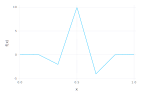

In [51]:
plot(g, 0,1)

In [52]:
N = 10^3;

In [53]:
range = 0:N-1;

In [54]:
X = [k for k in range];

In [55]:
Y = [g(k/N) for k in range];

In [56]:
Yc = smoothed_curvature(X,Y);

length(y) = 992
length(x) = 992


In [57]:
length(Yc)

990

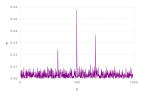

In [58]:
plot(x=[k for k in 1:990], y=Yc,Geom.line, color=[colorant"purple"])

In [59]:
xxx = [1,2,8,12]

4-element Vector{Int64}:
  1
  2
  8
 12

In [60]:
yyy = [5,8,9,14]

4-element Vector{Int64}:
  5
  8
  9
 14

In [61]:
[[xxx[k] - xxx[k+1], yyy[k] - yyy[k+1]]  for k in 1:3]

3-element Vector{Vector{Int64}}:
 [-1, -3]
 [-6, -1]
 [-4, -5]

In [62]:
[xxx[k+1]^2 - xxx[k]^2 + yyy[k+1]^2 - yyy[k]^2 for k in 1:3-1]

2-element Vector{Int64}:
 42
 77

In [63]:
function circle_fit(x::Array, y::Array)
    n = length(x)
    M = [[x[k] - x[k+1], y[k] - y[k+1]]  for k in 1:n-1] 
    M = reduce(hcat, M)*M
    b = [x[k+1]^2 - x[k]^2 + y[k+1]^2 - y[k]^2 for k in 1:n-1]
    M
end

circle_fit (generic function with 1 method)

In [64]:
ppp = circle_fit(xxx,yyy)

2-element Vector{Vector{Int64}}:
 [53, 29]
 [29, 35]

In [65]:
reduce(hcat,ppp)

2×2 Matrix{Int64}:
 53  29
 29  35

In [66]:
? vcat

search: vcat hvcat VecOrMat DenseVecOrMat StridedVecOrMat AbstractVecOrMat



```
vcat(A...)
```

Concatenate along dimension 1.

# Examples

```jldoctest
julia> a = [1 2 3 4 5]
1×5 Matrix{Int64}:
 1  2  3  4  5

julia> b = [6 7 8 9 10; 11 12 13 14 15]
2×5 Matrix{Int64}:
  6   7   8   9  10
 11  12  13  14  15

julia> vcat(a,b)
3×5 Matrix{Int64}:
  1   2   3   4   5
  6   7   8   9  10
 11  12  13  14  15

julia> c = ([1 2 3], [4 5 6])
([1 2 3], [4 5 6])

julia> vcat(c...)
2×3 Matrix{Int64}:
 1  2  3
 4  5  6
```
